In [3]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [ ]:
pip install --quiet git+https://github.com/theislab/scgen.git

Note: you may need to restart the kernel to use updated packages.


In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:28: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy import sparse


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


### Import the metric -- scib

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install --quiet scib
import scib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.2 MB/s eta 0:00:00


In [2]:
!pip install --quiet louvain
import louvain

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<ipython-input-2-bf0d4c071418>:2: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be

In [5]:
import anndata
adata = anndata.read_h5ad("../macaque_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 30302 × 36162
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH'
    var: 'gene_name'

In [6]:
## Setting: randomly missing labels
np.random.seed(666)
total_cells = adata.n_obs

# Calculate the number of cells to label
num_labeled = int(0.7 * total_cells)

# Initialize all labels with NaN
semi_labels = pd.Series(np.nan, index=adata.obs.index)

# Randomly select 70% of the indices without replacement
indices = np.random.choice(adata.obs.index, size=num_labeled, replace=False)

# Assign the corresponding 'cell_type' labels to these selected indices
semi_labels.loc[indices] = adata.obs.loc[indices, 'cell_type']

# Now 'semi_labels' contains 70% known labels and 30% NaN
adata.obs['hard_label'] = semi_labels
#when the method requires fillna, ssSTACAS do not need this filling, but scANVI requires)
adata.obs['hard_label'].fillna("Unknown", inplace=True)
adata.obs['hard_label'] = adata.obs['hard_label'].astype('category')

In [12]:
# Save the new_labels column to a CSV file
adata.obs[['hard_label']].to_csv('../R_macaque/labels/hard_label_macaque_30.csv', index=True)

In [7]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [8]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# scANVI

In [15]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [9]:
# Load the pretrained models
adata = adata.copy()
# Setup anndata with the same parameters used for training
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


In [10]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

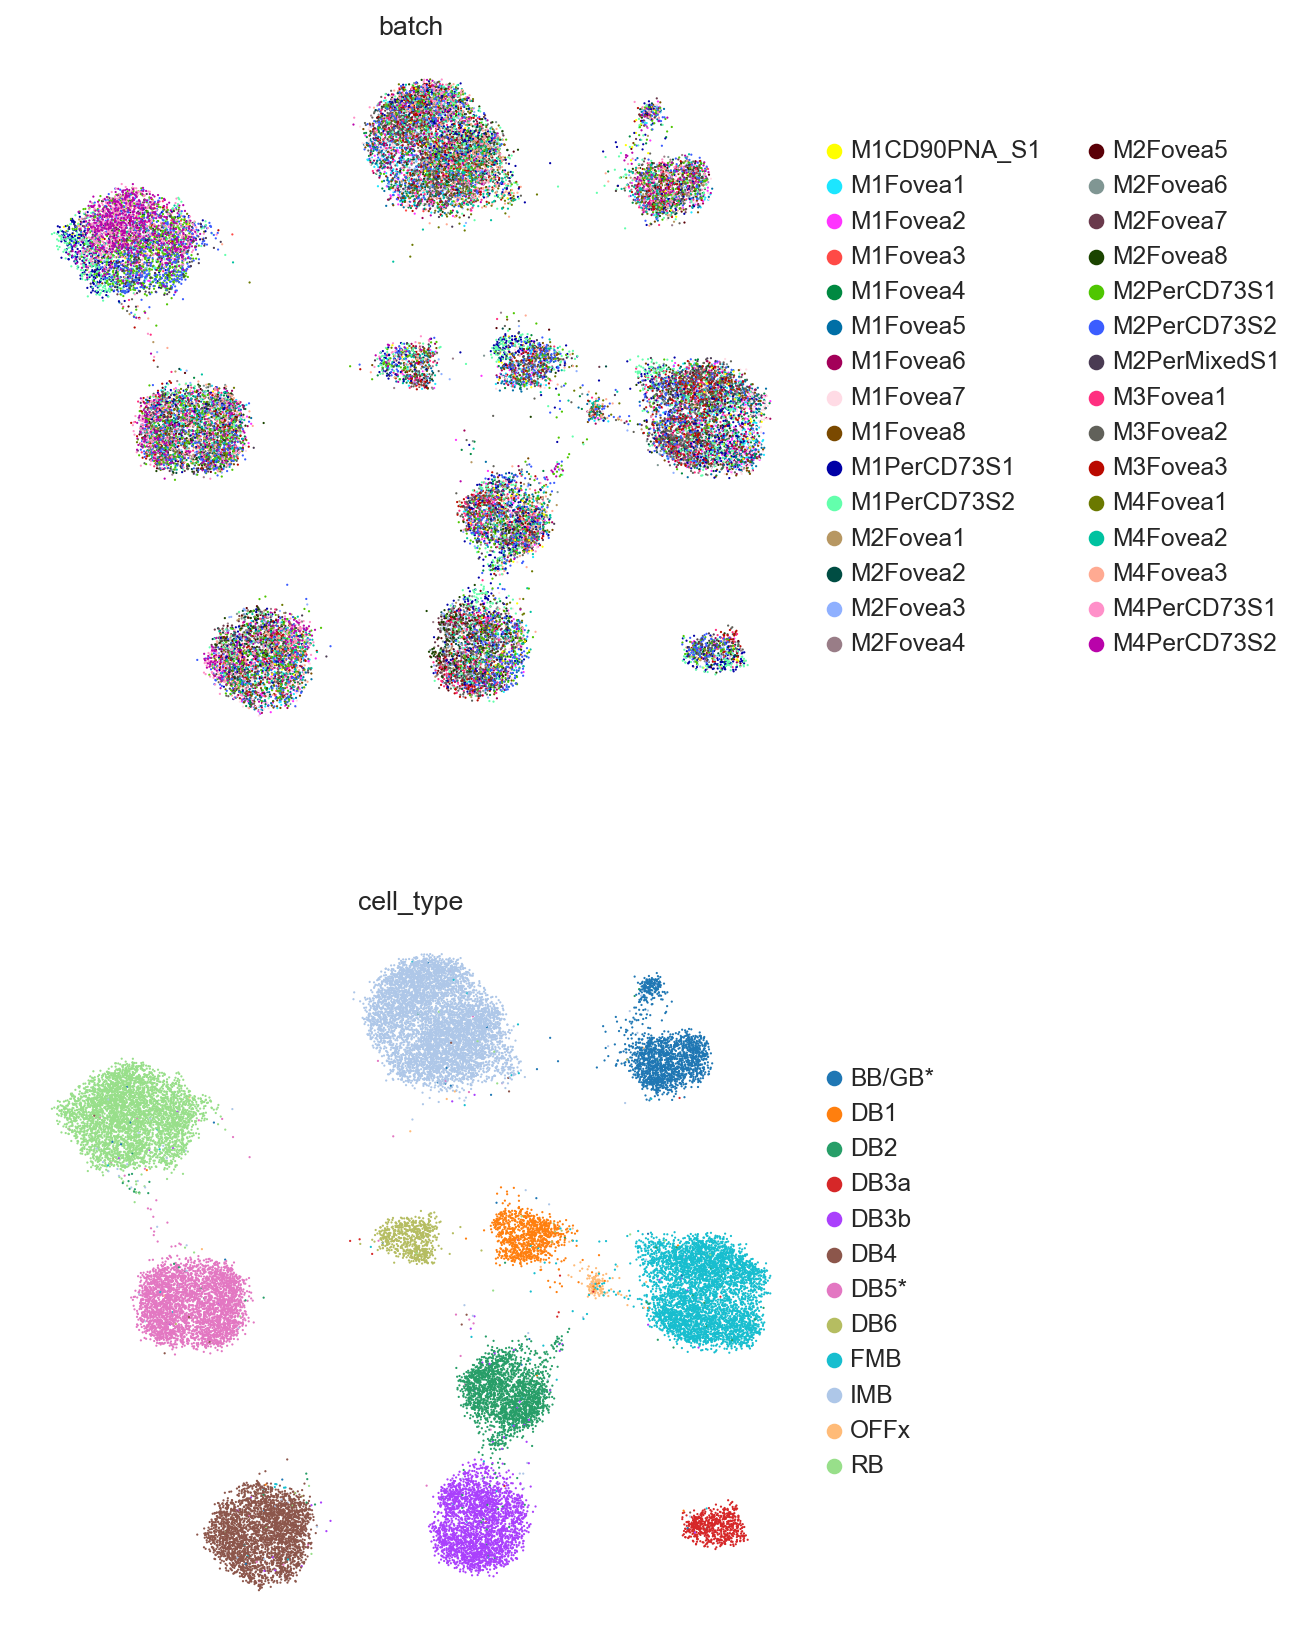

In [12]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [11]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="hard_label",
    unlabeled_category="Unknown",
)

In [13]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|█| 20/20 [03:20<00:00, 10.69s/it, v_num=1, train_loss_step=390

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [03:20<00:00, 10.01s/it, v_num=1, train_loss_step=390


In [14]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [15]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [16]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

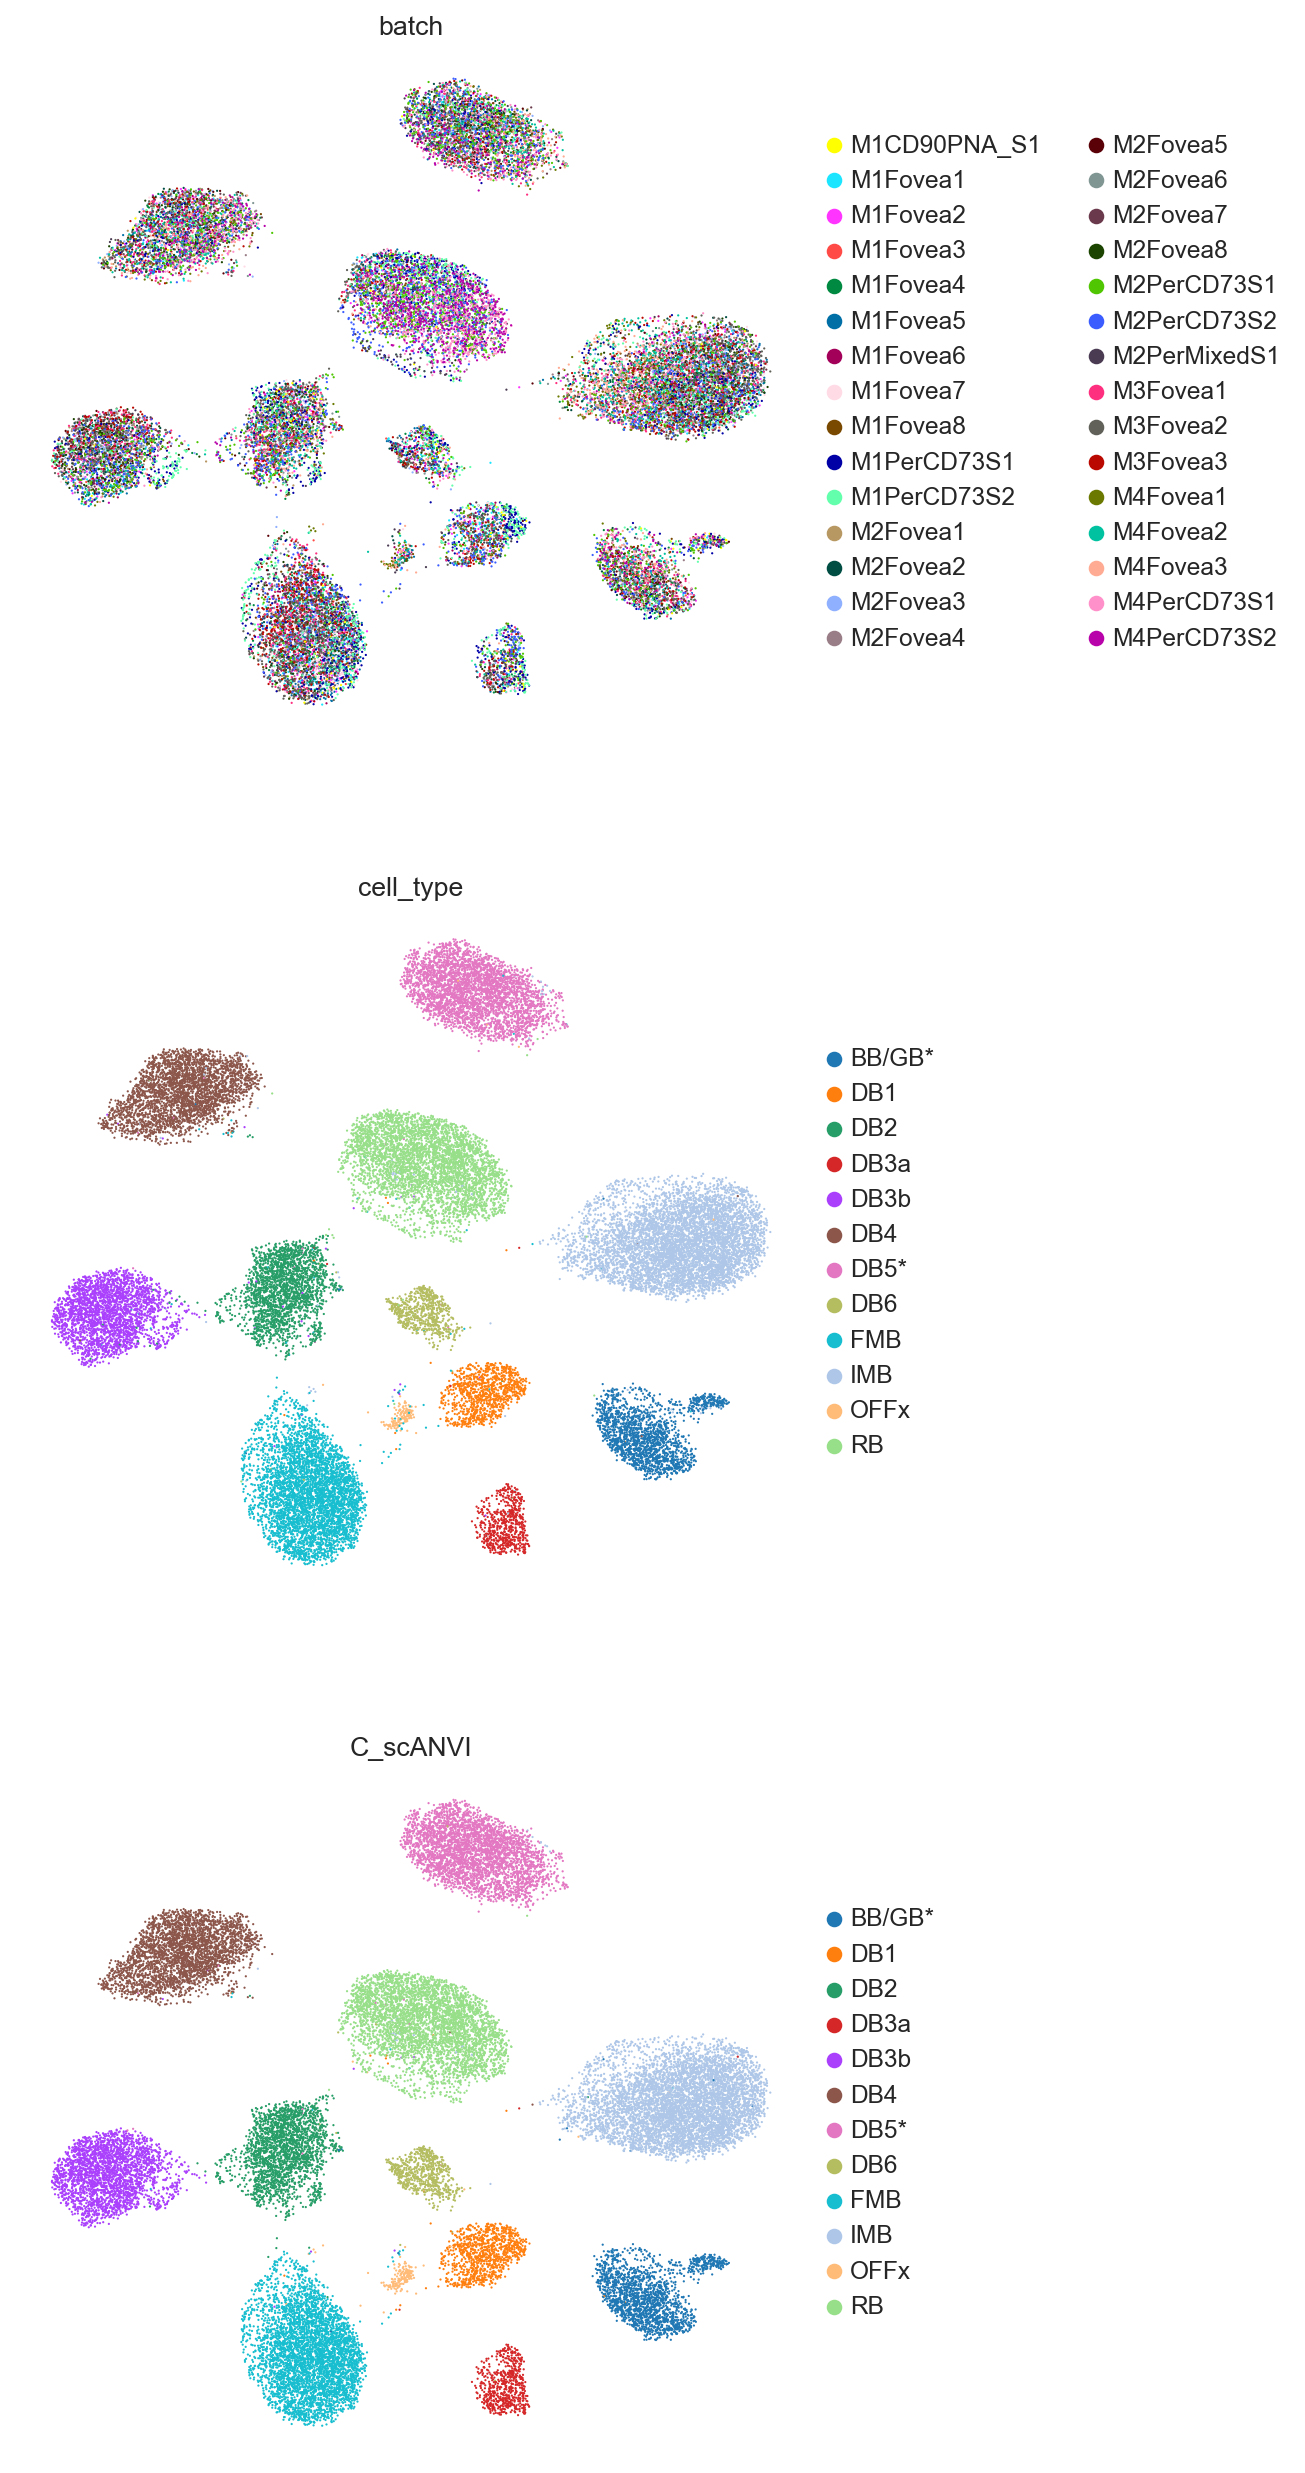

In [17]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [18]:
train = adata.copy()

### Preprocessing Data

In [19]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="hard_label")

## Creating and Training the model¶

In [20]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 27/100:  27%|▎| 27/100 [08:32<23:06, 19.00s/it, v_num=1, train_loss_step=1
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1143.319. Signaling Trainer to stop.


## Batch-Removal

In [21]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 30302 × 2000
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH', 'hard_label', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [22]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [23]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

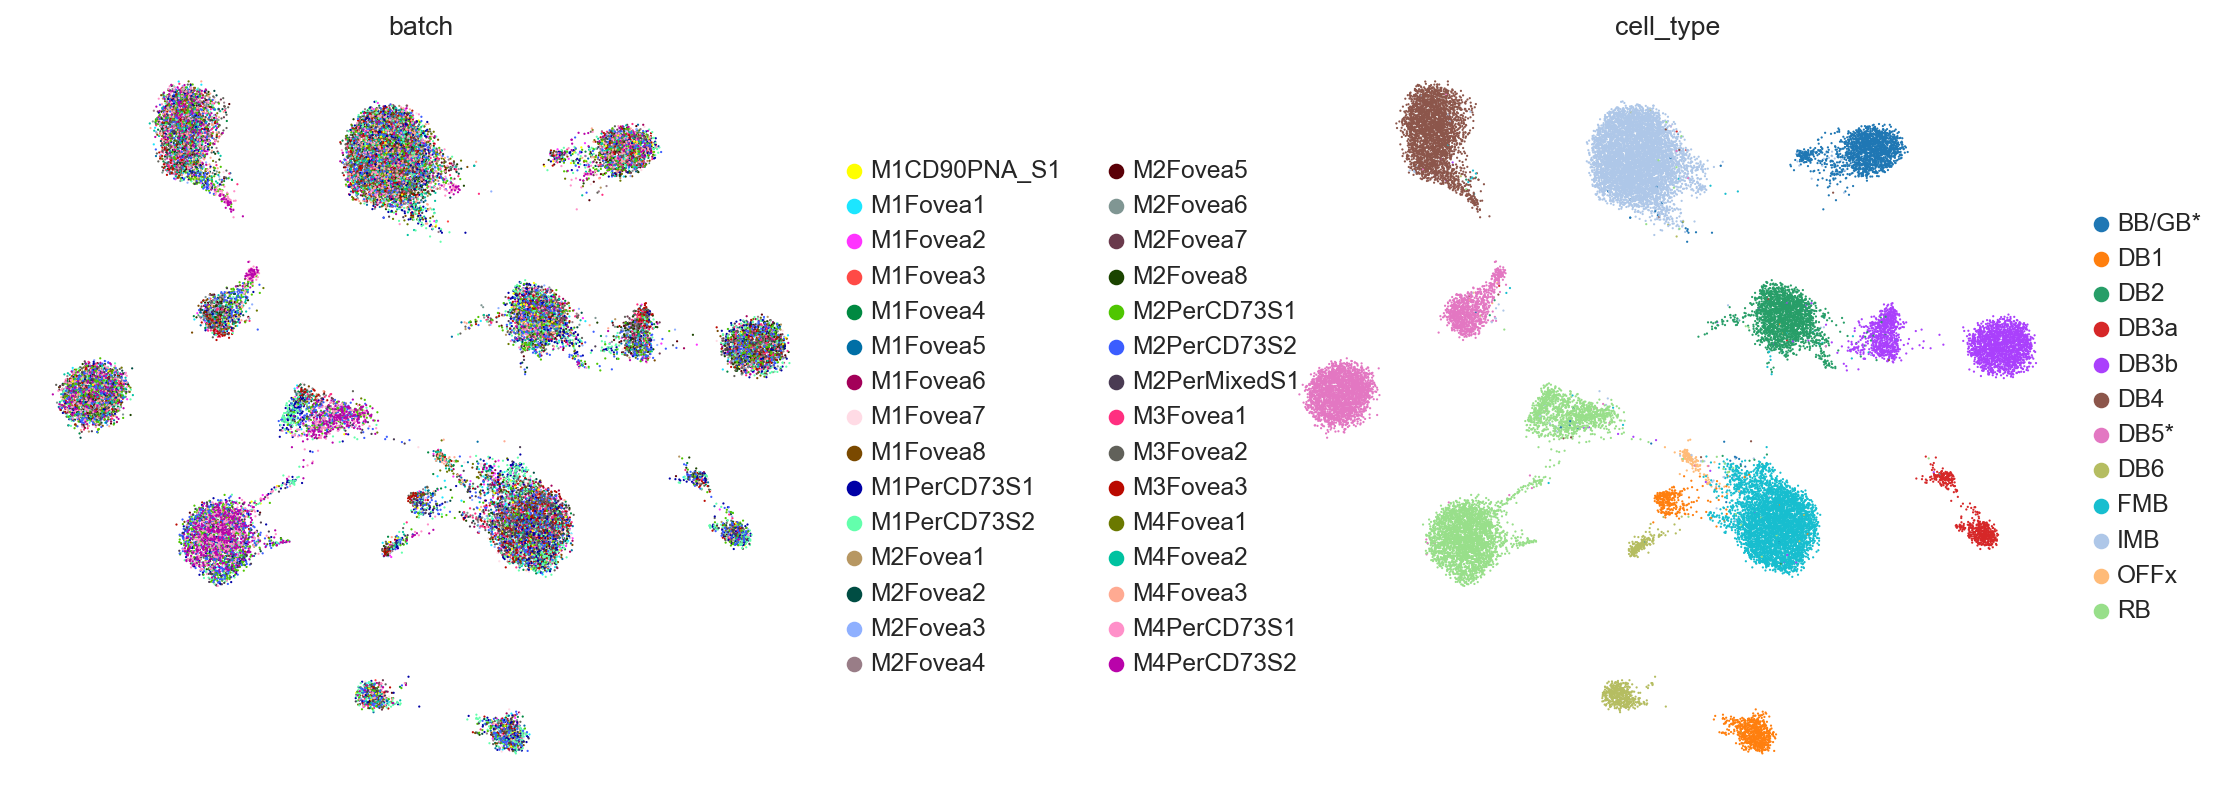

In [24]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [25]:
pca_embeddings = pd.read_csv('../R_macaque/embeddings/macaque_stacas_embeddings_randomly_missing_labels_30.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [26]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

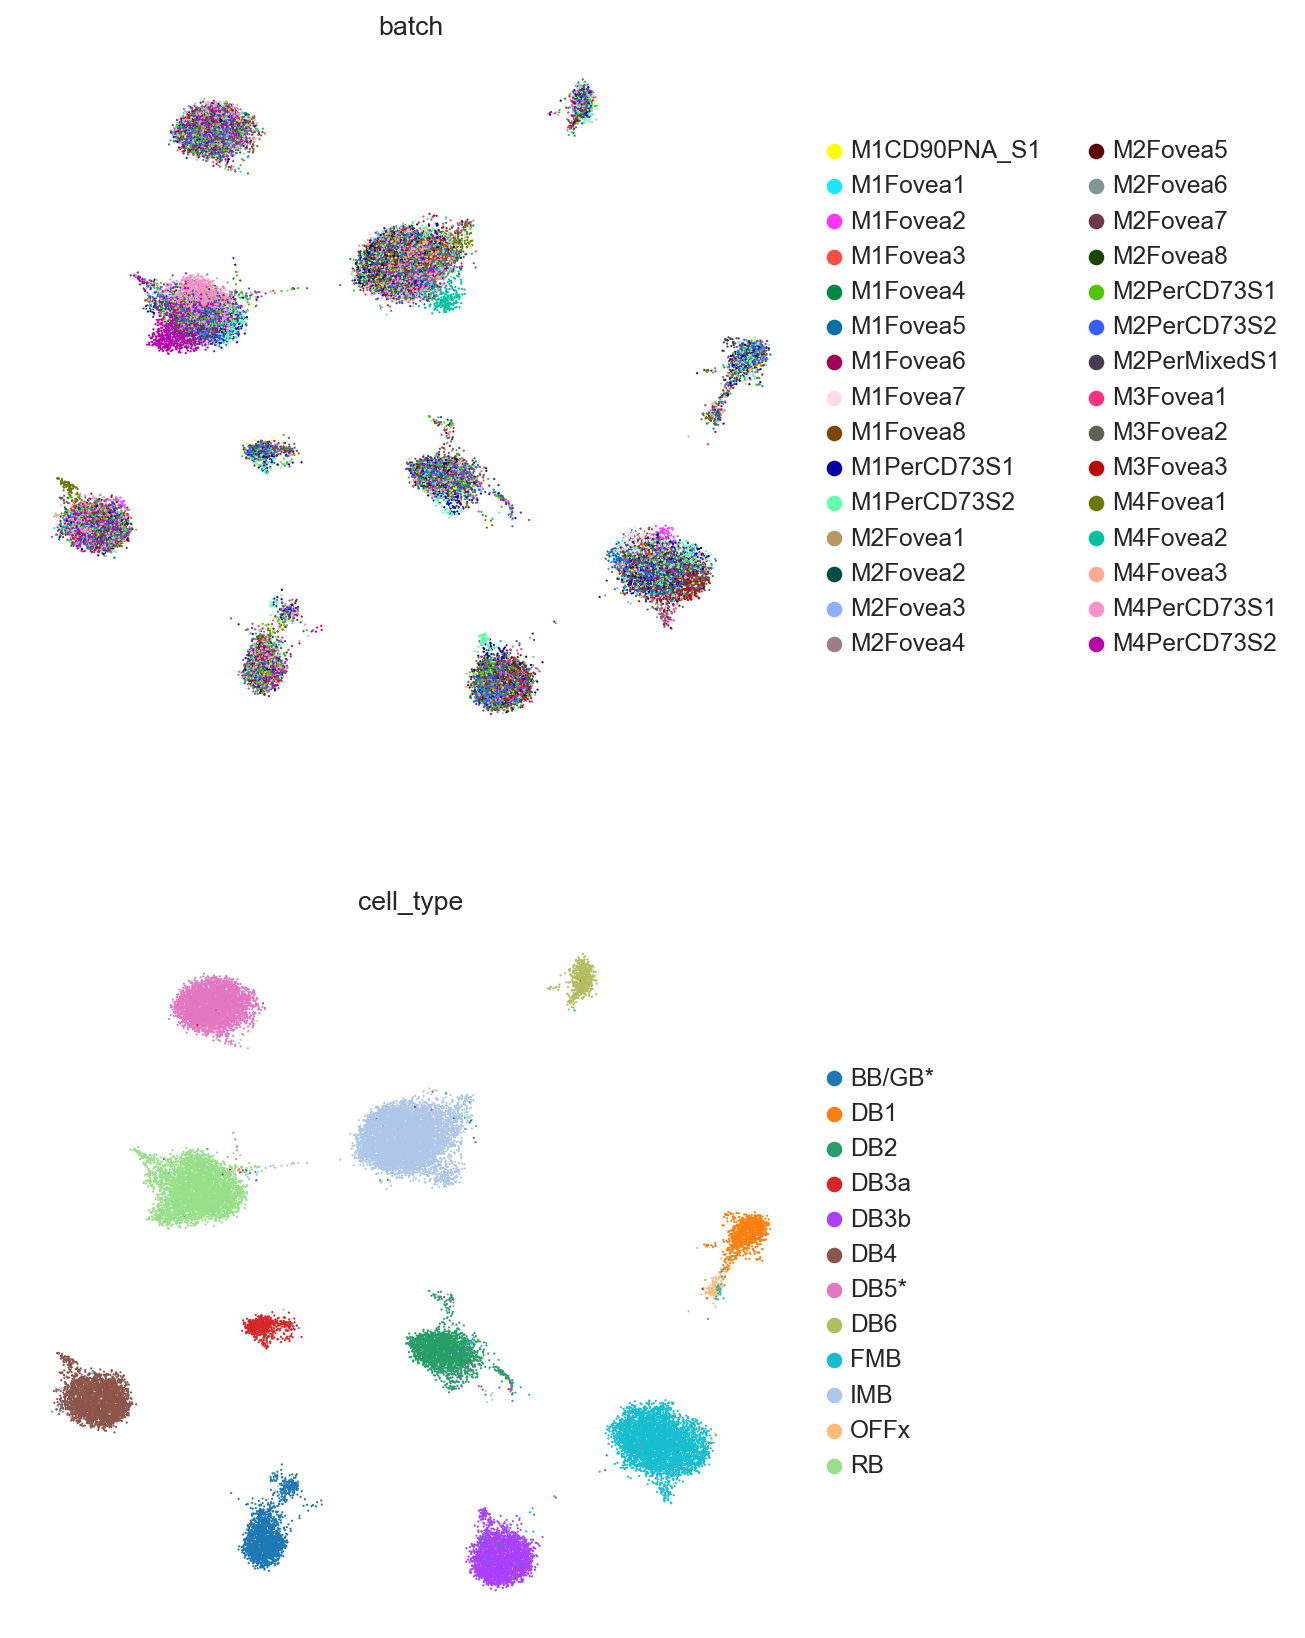

In [27]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [28]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/randomly_missing_macaque_30.csv")


# Metric Evaluation

## read the embeddings

In [39]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/randomly_missing_macaque_30.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [40]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.9718528642606945
resolution: 0.2, nmi: 0.9271302589332543
resolution: 0.3, nmi: 0.9063203200717024
resolution: 0.4, nmi: 0.9079398492459747
resolution: 0.5, nmi: 0.9075829196639192
resolution: 0.6, nmi: 0.9000133999487876
resolution: 0.7, nmi: 0.8893203959105144
resolution: 0.8, nmi: 0.8894544660524533
resolution: 0.9, nmi: 0.8886790270771179
resolution: 1.0, nmi: 0.8884935570742544
resolution: 1.1, nmi: 0.8867935809233782
resolution: 1.2, nmi: 0.8777803262819475
resolution: 1.3, nmi: 0.8779005656350242
resolution: 1.4, nmi: 0.8605930510729513
resolution: 1.5, nmi: 0.8482996631947778
resolution: 1.6, nmi: 0.8494570870024549
resolution: 1.7, nmi: 0.8349462213065966
resolution: 1.8, nmi: 0.8332834033890857
resolution: 1.9, nmi: 0.8330252997618875
resolution: 2.0, nmi: 0.8245553171495414
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.9718528642606945
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors o

In [42]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

resolution: 0.1, nmi: 0.7869923292902982
resolution: 0.2, nmi: 0.8907717048869341
resolution: 0.3, nmi: 0.894326616041867
resolution: 0.4, nmi: 0.8946843640931289
resolution: 0.5, nmi: 0.897348756069052
resolution: 0.6, nmi: 0.8972400460936084
resolution: 0.7, nmi: 0.884993944939833
resolution: 0.8, nmi: 0.8840618359542223
resolution: 0.9, nmi: 0.8840915504187455
resolution: 1.0, nmi: 0.8621694633062811
resolution: 1.1, nmi: 0.8663027264948046
resolution: 1.2, nmi: 0.8446158376960518
resolution: 1.3, nmi: 0.8396990119399924
resolution: 1.4, nmi: 0.8378638319138796
resolution: 1.5, nmi: 0.8431336937928332
resolution: 1.6, nmi: 0.8237056584560688
resolution: 1.7, nmi: 0.8241469777793358
resolution: 1.8, nmi: 0.8256011839473634
resolution: 1.9, nmi: 0.8184510057429704
resolution: 2.0, nmi: 0.82799401781683
optimised clustering against cell_type
optimal cluster resolution: 0.5
optimal score: 0.897348756069052
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep 

In [43]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

resolution: 0.1, nmi: 0.9443269284652175
resolution: 0.2, nmi: 0.914482333752829
resolution: 0.3, nmi: 0.8841595211196234
resolution: 0.4, nmi: 0.8841462121579418
resolution: 0.5, nmi: 0.863574286843257
resolution: 0.6, nmi: 0.8561542255995752
resolution: 0.7, nmi: 0.8450247435001478
resolution: 0.8, nmi: 0.8425317376097986
resolution: 0.9, nmi: 0.8273031943340543
resolution: 1.0, nmi: 0.8230827241900233
resolution: 1.1, nmi: 0.8042487335541201
resolution: 1.2, nmi: 0.8047111397374374
resolution: 1.3, nmi: 0.8022383180550747
resolution: 1.4, nmi: 0.803116874643517
resolution: 1.5, nmi: 0.802348774106638
resolution: 1.6, nmi: 0.792965858782243
resolution: 1.7, nmi: 0.7954558400860373
resolution: 1.8, nmi: 0.7801759664409661
resolution: 1.9, nmi: 0.7821592418988037
resolution: 2.0, nmi: 0.7829564416978889
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.9443269284652175
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep

In [44]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df.to_csv("../metrics/macaque_metrics_randomly_missing_30.csv", index=True)

In [45]:
merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.970898,0.902073,0.948359
ARI_cluster/label,0.977974,0.899013,0.962096
ASW_label,0.683693,0.541336,0.619845
ASW_label/batch,0.930091,0.935336,0.926425
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.988524,0.948445,0.964322
isolated_label_silhouette,0.680267,0.546636,0.615662
graph_conn,0.995934,0.993975,0.995167
kBET,NaN,NaN,NaN
